# Implementing a Low Rank Adapter (LoRA) (8 points)

Objective of this exercice:

Given a neural network (NN) classifier pre-trained on the subset of MNIST containing digits 0...4,
you will fine-tune this NN, by optimizing all weights, and compare the test accuracy of this baseline model versus fine-tuning a LoRA.

The neural network that we will define is artificially big because LoRA is usually applied to Large Language Models of billions of parameters

**What is a LoRA ?**

LoRA (Low-Rank Adaptation of Large Language Models) is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.

<div style="display: flex; justify-content: space-between;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_fig.png' style="width: 30%;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_text.png' style="width: 70%;">
</div>



References:

https://arxiv.org/pdf/2106.09685.pdf

https://lightning.ai/pages/community/tutorial/lora-llm/

https://huggingface.co/docs/diffusers/main/en/training/lora


In [16]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.utils.parametrize as parametrize
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Make torch deterministic
_ = torch.manual_seed(0)


# Decide which device we want to run on
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [17]:
#Normalizing MNIST
#These values are the mean and std deviation of the MNIST dataset.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# load MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# keep images of desired labels
class_names = [0, 1, 2, 3, 4]

# create a mask to filter indices for each label
train_mask = torch.tensor([label in class_names for label in mnist_train.targets])
test_mask = torch.tensor([label in class_names for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset = Subset(mnist_train, torch.where(train_mask)[0])
test_dataset = Subset(mnist_test, torch.where(test_mask)[0])

# split train into train & validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size=128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [18]:
len(train_dataset),len(val_dataset),len(test_dataset)

(21417, 9179, 5139)

# Architecture of the classifier

In [19]:
#note that last layer has 5 neurons for digits 0...4
#and the same layer will be used for 5...9

class classifier(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super(classifier,self).__init__()

        self.linear1 = nn.Linear(28*28, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 5)
        self.relu = nn.ReLU()


        self.dropout = nn.Dropout(0.5)



    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x

net = classifier().to(device)

# Code for training loop & validation

In [20]:
#We set a lower learning rate when we will fine-tune on the subset of MNIST containing digits 5...9
#so that fine-tuning don't change pre-training weights too much.

#Since the NN is big, we add weight decay to regularize it otherwise it will overfit too much too fast
def adjust_optimizer(name, parameters):
    lr = 0.001
    if name == "subset2":
        lr = 0.00001
    return torch.optim.Adam(parameters, lr=lr, weight_decay=0.0001)

#to do label prediction during training we use argmax on the last layer, which output a vector of 5 components
#so y_hat will be between 0 and 4, we thus have to "translate" y_true so that it's in the right range

# the name variable will be used later on to recognize on which dataset we are
# and do the corresponding label translation, and set the good hyperparameters
def process_labels(name, labels):
    if 'subset2' in name:
        labels = labels - 5
    return labels


def run_epoch(loader, name, net, optimizer, cross_el, total_iterations_limit=None):
    net.train() if optimizer else net.eval()

    loss_sum = 0
    num_iterations = 0

    data_iterator = tqdm(loader, desc=f'Training' if optimizer else f'Validation')
    if total_iterations_limit is not None:
        data_iterator.total = total_iterations_limit

    for data in data_iterator:
        num_iterations += 1
        x, y = data
        x, y = x.to(device), y.to(device)
        x = x.view(-1, 28*28)
        optimizer.zero_grad() if optimizer else None
        output = net(x)
        loss = cross_el(output, process_labels(name, y))
        loss_sum += loss.item()
        avg_loss = loss_sum / num_iterations
        data_iterator.set_postfix(loss=avg_loss)
        if optimizer:
            loss.backward()
            optimizer.step()

    return loss_sum / len(data_iterator)

def train(train_loader, val_loader, name, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = adjust_optimizer(name, net.parameters())

    total_iterations = 0
    train_loss_lst, val_loss_lst = [], []

    for epoch in range(epochs):
        train_loss = run_epoch(train_loader, name, net, optimizer, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss}")
        train_loss_lst.append(train_loss)

        val_loss = run_epoch(val_loader, name, net, None, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Validation Loss: {val_loss}")
        val_loss_lst.append(val_loss)

    return train_loss_lst, val_loss_lst

In [21]:
def plot_losses(train_loss_lst, val_loss_lst):
    plt.plot(train_loss_lst,label="train")
    plt.plot(val_loss_lst,label="val")
    plt.legend()

# If you have GPU access, or simply want to train your own model, run this code

In [22]:
train_loss_lst, val_loss_lst = train(train_loader, val_loader, "subset1", net, epochs=30)

Training: 100%|██████████| 168/168 [00:06<00:00, 24.80it/s, loss=0.15]


Epoch [1/30] Train Loss: 0.14974932339308517


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.95it/s, loss=0.0825]


Epoch [1/30] Validation Loss: 0.08251338893185473


Training: 100%|██████████| 168/168 [00:05<00:00, 28.51it/s, loss=0.0727]


Epoch [2/30] Train Loss: 0.0727058290171304


Validation: 100%|██████████| 72/72 [00:02<00:00, 26.50it/s, loss=0.0739]


Epoch [2/30] Validation Loss: 0.07392260182597157


Training: 100%|██████████| 168/168 [00:05<00:00, 33.35it/s, loss=0.0526]


Epoch [3/30] Train Loss: 0.05263905182004064


Validation: 100%|██████████| 72/72 [00:02<00:00, 34.86it/s, loss=0.045]


Epoch [3/30] Validation Loss: 0.044970981440403394


Training: 100%|██████████| 168/168 [00:06<00:00, 26.00it/s, loss=0.051]


Epoch [4/30] Train Loss: 0.051019202169430046


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.50it/s, loss=0.0399]


Epoch [4/30] Validation Loss: 0.039921130816057686


Training: 100%|██████████| 168/168 [00:05<00:00, 30.31it/s, loss=0.0439]


Epoch [5/30] Train Loss: 0.04388246592550006


Validation: 100%|██████████| 72/72 [00:02<00:00, 25.64it/s, loss=0.057]


Epoch [5/30] Validation Loss: 0.05699470036132778


Training: 100%|██████████| 168/168 [00:05<00:00, 29.67it/s, loss=0.0388]


Epoch [6/30] Train Loss: 0.0388344281292077


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.46it/s, loss=0.0555]


Epoch [6/30] Validation Loss: 0.0555133964581829


Training: 100%|██████████| 168/168 [00:06<00:00, 26.61it/s, loss=0.0382]


Epoch [7/30] Train Loss: 0.03818635740650019


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.60it/s, loss=0.0471]


Epoch [7/30] Validation Loss: 0.04714426022757026


Training: 100%|██████████| 168/168 [00:06<00:00, 27.40it/s, loss=0.0322]


Epoch [8/30] Train Loss: 0.032195798712477665


Validation: 100%|██████████| 72/72 [00:02<00:00, 29.96it/s, loss=0.0435]


Epoch [8/30] Validation Loss: 0.04350943462062181


Training: 100%|██████████| 168/168 [00:05<00:00, 28.67it/s, loss=0.0325]


Epoch [9/30] Train Loss: 0.032548023160156196


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.69it/s, loss=0.0363]


Epoch [9/30] Validation Loss: 0.03634637334946294


Training: 100%|██████████| 168/168 [00:06<00:00, 27.13it/s, loss=0.0323]


Epoch [10/30] Train Loss: 0.032335361063208744


Validation: 100%|██████████| 72/72 [00:03<00:00, 22.82it/s, loss=0.0439]


Epoch [10/30] Validation Loss: 0.04394077951696494


Training: 100%|██████████| 168/168 [00:05<00:00, 28.04it/s, loss=0.0353]


Epoch [11/30] Train Loss: 0.03525609094746566


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.91it/s, loss=0.0402]


Epoch [11/30] Validation Loss: 0.04019067670136186


Training: 100%|██████████| 168/168 [00:06<00:00, 26.94it/s, loss=0.0289]


Epoch [12/30] Train Loss: 0.02887745749432638


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.16it/s, loss=0.048]


Epoch [12/30] Validation Loss: 0.047962664700106766


Training: 100%|██████████| 168/168 [00:05<00:00, 28.30it/s, loss=0.0332]


Epoch [13/30] Train Loss: 0.033212027780661756


Validation: 100%|██████████| 72/72 [00:02<00:00, 24.77it/s, loss=0.0495]


Epoch [13/30] Validation Loss: 0.04945662647716947


Training: 100%|██████████| 168/168 [00:05<00:00, 31.27it/s, loss=0.0241]


Epoch [14/30] Train Loss: 0.024146842429088013


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.51it/s, loss=0.0454]


Epoch [14/30] Validation Loss: 0.045374524898256316


Training: 100%|██████████| 168/168 [00:06<00:00, 27.22it/s, loss=0.0311]


Epoch [15/30] Train Loss: 0.031124311276514726


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.60it/s, loss=0.0622]


Epoch [15/30] Validation Loss: 0.062247429725781935


Training: 100%|██████████| 168/168 [00:05<00:00, 31.20it/s, loss=0.0277]


Epoch [16/30] Train Loss: 0.027696087993977665


Validation: 100%|██████████| 72/72 [00:02<00:00, 24.24it/s, loss=0.0529]


Epoch [16/30] Validation Loss: 0.0529151780938264


Training: 100%|██████████| 168/168 [00:05<00:00, 29.54it/s, loss=0.0261]


Epoch [17/30] Train Loss: 0.026115033389335924


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.98it/s, loss=0.042]


Epoch [17/30] Validation Loss: 0.04201710590723451


Training: 100%|██████████| 168/168 [00:06<00:00, 27.80it/s, loss=0.0265]


Epoch [18/30] Train Loss: 0.026536672590910235


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.67it/s, loss=0.0423]


Epoch [18/30] Validation Loss: 0.042308687057862296


Training: 100%|██████████| 168/168 [00:05<00:00, 30.44it/s, loss=0.0236]


Epoch [19/30] Train Loss: 0.023623232239472037


Validation: 100%|██████████| 72/72 [00:02<00:00, 30.27it/s, loss=0.0461]


Epoch [19/30] Validation Loss: 0.046063210224600776


Training: 100%|██████████| 168/168 [00:06<00:00, 26.68it/s, loss=0.0189]


Epoch [20/30] Train Loss: 0.018922397777628032


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.57it/s, loss=0.0467]


Epoch [20/30] Validation Loss: 0.046737306796962405


Training: 100%|██████████| 168/168 [00:05<00:00, 29.20it/s, loss=0.022]


Epoch [21/30] Train Loss: 0.02201877897451119


Validation: 100%|██████████| 72/72 [00:02<00:00, 26.06it/s, loss=0.0506]


Epoch [21/30] Validation Loss: 0.050577840019589836


Training: 100%|██████████| 168/168 [00:05<00:00, 30.74it/s, loss=0.0274]


Epoch [22/30] Train Loss: 0.027364984396453587


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.28it/s, loss=0.045]


Epoch [22/30] Validation Loss: 0.04503257767871421


Training: 100%|██████████| 168/168 [00:06<00:00, 25.25it/s, loss=0.027]


Epoch [23/30] Train Loss: 0.026974615275575854


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.21it/s, loss=0.046]


Epoch [23/30] Validation Loss: 0.04601384805662039


Training: 100%|██████████| 168/168 [00:05<00:00, 32.23it/s, loss=0.0247]


Epoch [24/30] Train Loss: 0.024679075321121974


Validation: 100%|██████████| 72/72 [00:02<00:00, 25.24it/s, loss=0.052]


Epoch [24/30] Validation Loss: 0.051963286942938995


Training: 100%|██████████| 168/168 [00:05<00:00, 28.76it/s, loss=0.0227]


Epoch [25/30] Train Loss: 0.02269305546247952


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.44it/s, loss=0.0425]


Epoch [25/30] Validation Loss: 0.04245810768144212


Training: 100%|██████████| 168/168 [00:06<00:00, 26.45it/s, loss=0.0244]


Epoch [26/30] Train Loss: 0.024409375068769026


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.31it/s, loss=0.0426]


Epoch [26/30] Validation Loss: 0.0425777312912285


Training: 100%|██████████| 168/168 [00:05<00:00, 30.99it/s, loss=0.026]


Epoch [27/30] Train Loss: 0.02596881687198523


Validation: 100%|██████████| 72/72 [00:02<00:00, 30.57it/s, loss=0.0372]


Epoch [27/30] Validation Loss: 0.03724991662567037


Training: 100%|██████████| 168/168 [00:06<00:00, 26.70it/s, loss=0.0276]


Epoch [28/30] Train Loss: 0.027648606950043314


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.48it/s, loss=0.0443]


Epoch [28/30] Validation Loss: 0.04432549775060579


Training: 100%|██████████| 168/168 [00:05<00:00, 29.09it/s, loss=0.0292]


Epoch [29/30] Train Loss: 0.029202995721615957


Validation: 100%|██████████| 72/72 [00:02<00:00, 26.97it/s, loss=0.0453]


Epoch [29/30] Validation Loss: 0.04532906108960964


Training: 100%|██████████| 168/168 [00:05<00:00, 29.39it/s, loss=0.017]


Epoch [30/30] Train Loss: 0.016994555830738785


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.68it/s, loss=0.0497]

Epoch [30/30] Validation Loss: 0.049672105197689435


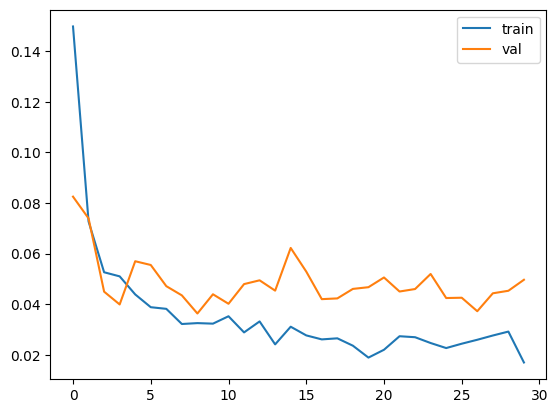

In [23]:
plot_losses(train_loss_lst,val_loss_lst)

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# save the model
path1 = '/content/drive/My Drive/full_model.pth'
torch.save(net,path1)

path2 = '/content/drive/My Drive/state_dict_model.pth'
# Save the state dictionary
torch.save(net.state_dict(), path2)

# Otherwise load an already pre-trained model
Either the one you have created above, either the one already available at https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/models/


In [26]:
net=torch.load(path1).to(device)

# Count the number of weights & compare it with parameters added by LoRA

In [27]:
original_weights = {}
for name, param in net.named_parameters():
    original_weights[name] = param.clone().detach()

In [28]:
# Print the size of the weights matrices of the network
# Save the count of the total number of parameters
net.eval()
total_parameters_original = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')


Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([5, 2000]) + B: torch.Size([5])
Total number of parameters: 2,797,005


# Test the model on digits 0...4

In [29]:
def test(loader, name, net, wrong_counts):
    correct = 0
    total = 0

    net.eval()
    with torch.no_grad():
        for data in tqdm(loader, desc=name):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y = process_labels(name, y)
            output = net(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                else:
                    wrong_digit = y[idx].item() + 5 if 'subset2' in name else y[idx].item()
                    wrong_counts[wrong_digit] += 1

                total += 1

    accuracy = round(correct / total, 3)
    print(f'Accuracy: {accuracy}')
    for key, value in wrong_counts.items():
        print(f'Wrong counts for the digit {key}: {value}')

    return accuracy

test(test_loader, "Testing", net, {i: 0 for i in range(5)})


Testing: 100%|██████████| 41/41 [00:01<00:00, 29.60it/s]

Accuracy: 0.992
Wrong counts for the digit 0: 4
Wrong counts for the digit 1: 9
Wrong counts for the digit 2: 18
Wrong counts for the digit 3: 6
Wrong counts for the digit 4: 5


0.992

# Define train, validation, test sets for digits 5...9

__Question 1 (0.25 points) :__

In [30]:
#same code as before except for the mask

# create a mask to filter indices for each label, retrieve digits 5...9
#######
#TO-DO#

# keep images of desired labels
class_names_subset2 = [5, 6, 7, 8, 9]

# create a mask to filter indices for each label
train_mask_subset2 = torch.tensor([label in class_names_subset2 for label in mnist_train.targets])
test_mask_subset2 = torch.tensor([label in class_names_subset2 for label in mnist_test.targets])

#######

# Create Subset datasets for train, validation, and test
train_dataset_subset2 = Subset(mnist_train, torch.where(train_mask_subset2)[0])
test_dataset_subset2 = Subset(mnist_test, torch.where(test_mask_subset2)[0])

# split train into train & validation
train_size_subset2 = int(0.7 * len(train_dataset_subset2))
val_size_subset2 = len(train_dataset_subset2) - train_size_subset2
train_dataset_subset2, val_dataset_subset2 = random_split(train_dataset_subset2, [train_size_subset2, val_size_subset2])

train_loader_subset2 = DataLoader(train_dataset_subset2, batch_size=batch_size, shuffle=True)
val_loader_subset2 = DataLoader(val_dataset_subset2, batch_size=batch_size, shuffle=False)
test_loader_subset2 = DataLoader(test_dataset_subset2, batch_size=batch_size, shuffle=False)


# Verify that pre-trained model on digits 0...4 is bad on digits 5...9

__Question 2 (0.25 points) :__

You should display the number of wrong predictions for each digits & global accuracy. \
Note that it's better than random guess ($\frac{1}{5}\times 100= $20%) for digit 8 and 9 because 3 looks like 8 and 4 looks like 9


In [31]:
#######
#TO-DO#

test(test_loader_subset2, "subset2", net, {i: 0 for i in range(5, 10)})

#######

subset2: 100%|██████████| 38/38 [00:01<00:00, 28.45it/s]

Accuracy: 0.413
Wrong counts for the digit 5: 772
Wrong counts for the digit 6: 952
Wrong counts for the digit 7: 600
Wrong counts for the digit 8: 454
Wrong counts for the digit 9: 77


0.413

# Fine-tune the model on digits 5...9

__Question 3 (0.5 points) :__

You will fine-tune all the layers of the model (ie. all parameters of all fully-connected matrices) for 10 epochs

In [32]:
#######
#TO-DO#

train_loss_lst_subset2, val_loss_lst_subset2 = train(train_loader_subset2, val_loader_subset2, "subset2", net, epochs=10)

#######

Training: 100%|██████████| 161/161 [00:05<00:00, 28.84it/s, loss=6.43]


Epoch [1/10] Train Loss: 6.427864995802412


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.28it/s, loss=4.81]


Epoch [1/10] Validation Loss: 4.809982576232025


Training: 100%|██████████| 161/161 [00:05<00:00, 27.41it/s, loss=4.18]


Epoch [2/10] Train Loss: 4.18086616445032


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.34it/s, loss=2.77]


Epoch [2/10] Validation Loss: 2.7743394461230957


Training: 100%|██████████| 161/161 [00:05<00:00, 30.72it/s, loss=2.51]


Epoch [3/10] Train Loss: 2.5101648013784277


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.59it/s, loss=1.58]


Epoch [3/10] Validation Loss: 1.5771643813105598


Training: 100%|██████████| 161/161 [00:06<00:00, 26.83it/s, loss=1.59]


Epoch [4/10] Train Loss: 1.5866312443839838


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.21it/s, loss=0.923]


Epoch [4/10] Validation Loss: 0.9234499970208043


Training: 100%|██████████| 161/161 [00:06<00:00, 26.43it/s, loss=1.03]


Epoch [5/10] Train Loss: 1.03356653340855


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.98it/s, loss=0.599]


Epoch [5/10] Validation Loss: 0.5987676256808682


Training: 100%|██████████| 161/161 [00:04<00:00, 32.85it/s, loss=0.74]


Epoch [6/10] Train Loss: 0.7404504834865191


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.61it/s, loss=0.452]


Epoch [6/10] Validation Loss: 0.45245300168576447


Training: 100%|██████████| 161/161 [00:05<00:00, 27.96it/s, loss=0.591]


Epoch [7/10] Train Loss: 0.591060661751291


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.27it/s, loss=0.371]


Epoch [7/10] Validation Loss: 0.3710174664207127


Training: 100%|██████████| 161/161 [00:04<00:00, 32.84it/s, loss=0.511]


Epoch [8/10] Train Loss: 0.510849620151964


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.03it/s, loss=0.318]


Epoch [8/10] Validation Loss: 0.3182447416626889


Training: 100%|██████████| 161/161 [00:05<00:00, 28.08it/s, loss=0.44]


Epoch [9/10] Train Loss: 0.4395721930524577


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.53it/s, loss=0.279]


Epoch [9/10] Validation Loss: 0.2794104589932207


Training: 100%|██████████| 161/161 [00:04<00:00, 32.74it/s, loss=0.385]


Epoch [10/10] Train Loss: 0.3854753666597864


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.07it/s, loss=0.25]

Epoch [10/10] Validation Loss: 0.2499320079451022


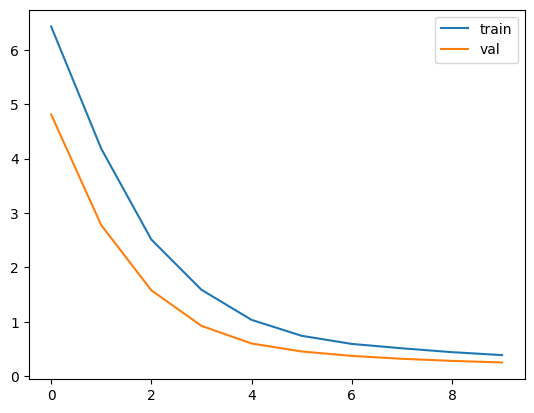

In [33]:
#plot the train and validation losses
#######
#TO-DO#

plot_losses(train_loss_lst_subset2, val_loss_lst_subset2)

#######

In [34]:
#test accuracy of fine-tuned model on digits 5...9
# & save this number into a variable, we will need it for final plot

#######
#TO-DO#

accuracy_subset2 = test(test_loader_subset2, "subset2", net, {i: 0 for i in range(5, 10)})

#######

subset2: 100%|██████████| 38/38 [00:01<00:00, 31.96it/s]

Accuracy: 0.93
Wrong counts for the digit 5: 85
Wrong counts for the digit 6: 32
Wrong counts for the digit 7: 67
Wrong counts for the digit 8: 91
Wrong counts for the digit 9: 66


# Fine-tune the model on digits 5...9 with LoRA

__Question 4 (2.5 points) :__

You will now implement one LoRA per layer

In [47]:
class ModifiedClassifier(nn.Module):
    def __init__(self, lora_rank):
        super(ModifiedClassifier, self).__init__()

        # Load the pretrained model
        self.pretrained_net = classifier().to(device)
        self.pretrained_net.load_state_dict(torch.load(path2))

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        # Define lora hyperparameters
        #######
        #TO-DO#

        self.lora_rank = lora_rank
        self.alpha = 64
        self.hidden_size1 = 1000
        self.hidden_size2 = 2000

        #######

        # Define lora weights matrices for each layer in pretrained model
        #######
        #TO-DO#

        self.l1_lora_A = nn.Parameter(torch.empty(self.lora_rank, 28*28))
        self.l1_lora_B = nn.Parameter(torch.empty(self.hidden_size1, self.lora_rank))

        self.l2_lora_A = nn.Parameter(torch.empty(self.lora_rank, self.hidden_size1))
        self.l2_lora_B = nn.Parameter(torch.empty(self.hidden_size2, self.lora_rank))

        self.l3_lora_A = nn.Parameter(torch.empty(self.lora_rank, self.hidden_size2))
        self.l3_lora_B = nn.Parameter(torch.empty(5, self.lora_rank))

        #######

        # Initialization for lora layers
        #######
        #TO-DO#

        nn.init.normal_(self.l1_lora_A)
        nn.init.zeros_(self.l1_lora_B)

        nn.init.normal_(self.l2_lora_A)
        nn.init.zeros_(self.l2_lora_B)

        nn.init.normal_(self.l3_lora_A)
        nn.init.zeros_(self.l3_lora_B)

        #######

        # freeze non lora weights
        #######
        #TO-DO#

        for name, param in self.pretrained_net.named_parameters():
          param.requires_grad = False

        #######

    def lora_linear(self, x, layer, lora_A, lora_B):
        #Implement formula (3) in arxiv.org/pdf/2106.09685.pdf
        h = layer(x) + (lora_B @ lora_A @ x.T).T * (self.alpha / self.lora_rank)
        return h


    def forward(self, input):
        x = input.view(-1, 28*28)

        # layer 1 (input size, hidden size)
        x = self.lora_linear(x, self.pretrained_net.linear1, self.l1_lora_A, self.l1_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        #complete the remaining code (layer 2 and 3)
        #######
        #TO-DO#

        # layer 2 (hidden size 1, hidden size 2)
        x = self.lora_linear(x, self.pretrained_net.linear2, self.l2_lora_A, self.l2_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 3 (hidden size 2, output size)
        x = self.lora_linear(x, self.pretrained_net.linear3, self.l3_lora_A, self.l3_lora_B)

        #######

        return x


lora_rank=1
# Create an instance of the modified network
modified_net = ModifiedClassifier(lora_rank).to(device)


Make a function that counts the number of parameters introduced by lora ( use the function torch.numel() )

In [48]:
# Count the parameters introduced by lora layers
#######
#TO-DO#

def CountLoraLayerParameters(net):
  net.eval()
  total_lora_parameters = 0
  for name, param in net.named_parameters():
    if 'lora' in name:
      total_lora_parameters += torch.numel(param)
      print(f'LoRA Layer {name}: {torch.numel(param)}')
  print(f'Total number of parameters: {total_lora_parameters:,}')

  return total_lora_parameters

CountLoraLayerParameters(modified_net)

#######

LoRA Layer l1_lora_A: 784
LoRA Layer l1_lora_B: 1000
LoRA Layer l2_lora_A: 1000
LoRA Layer l2_lora_B: 2000
LoRA Layer l3_lora_A: 2000
LoRA Layer l3_lora_B: 5
Total number of parameters: 6,789


6789

# Fine-Tune using LoRA of rank 1

__Question 5 (0.5 points) :__

In [49]:
#Fine tune this new model with loras of rank 1, on MNIST 5...9
#######
#TO-DO#

train_loss_lst_lora, val_loss_lst_lora = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=10)

#######

Training: 100%|██████████| 161/161 [00:06<00:00, 25.09it/s, loss=4.53]


Epoch [1/10] Train Loss: 4.533475413085511


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.12it/s, loss=1.89]


Epoch [1/10] Validation Loss: 1.8858754185662754


Training: 100%|██████████| 161/161 [00:05<00:00, 29.41it/s, loss=2.33]


Epoch [2/10] Train Loss: 2.3347342480783877


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.41it/s, loss=1.22]


Epoch [2/10] Validation Loss: 1.2179256677627563


Training: 100%|██████████| 161/161 [00:06<00:00, 26.66it/s, loss=1.75]


Epoch [3/10] Train Loss: 1.7482229337929198


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.51it/s, loss=0.999]


Epoch [3/10] Validation Loss: 0.998968243598938


Training: 100%|██████████| 161/161 [00:05<00:00, 27.02it/s, loss=1.52]


Epoch [4/10] Train Loss: 1.520773256417387


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.26it/s, loss=0.902]


Epoch [4/10] Validation Loss: 0.9020550406497457


Training: 100%|██████████| 161/161 [00:04<00:00, 32.21it/s, loss=1.33]


Epoch [5/10] Train Loss: 1.328092368493169


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.71it/s, loss=0.845]


Epoch [5/10] Validation Loss: 0.8454574692076531


Training: 100%|██████████| 161/161 [00:06<00:00, 25.49it/s, loss=1.26]


Epoch [6/10] Train Loss: 1.2648116753708503


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.87it/s, loss=0.809]


Epoch [6/10] Validation Loss: 0.8089479264141857


Training: 100%|██████████| 161/161 [00:05<00:00, 29.46it/s, loss=1.17]


Epoch [7/10] Train Loss: 1.1693926020438627


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.14it/s, loss=0.768]


Epoch [7/10] Validation Loss: 0.7675780472548112


Training: 100%|██████████| 161/161 [00:05<00:00, 29.15it/s, loss=1.16]


Epoch [8/10] Train Loss: 1.155664432863271


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.86it/s, loss=0.746]


Epoch [8/10] Validation Loss: 0.746287734180257


Training: 100%|██████████| 161/161 [00:06<00:00, 24.75it/s, loss=1.12]


Epoch [9/10] Train Loss: 1.1157777923974932


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.98it/s, loss=0.725]


Epoch [9/10] Validation Loss: 0.7247126521407694


Training: 100%|██████████| 161/161 [00:05<00:00, 30.32it/s, loss=1.09]


Epoch [10/10] Train Loss: 1.0934413086553538


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.12it/s, loss=0.714]

Epoch [10/10] Validation Loss: 0.7137466543826504


In [50]:
# Check that the frozen parameters are still unchanged by the finetuning
# Remember the dictionary "original_weights"
#######
#TO-DO#

for name, param in modified_net.pretrained_net.named_parameters():
    assert torch.equal(original_weights[name], param), "Weights have changed for frozen parameter"
print("Frozen parameters are unchanged.")

#######

Frozen parameters are unchanged.


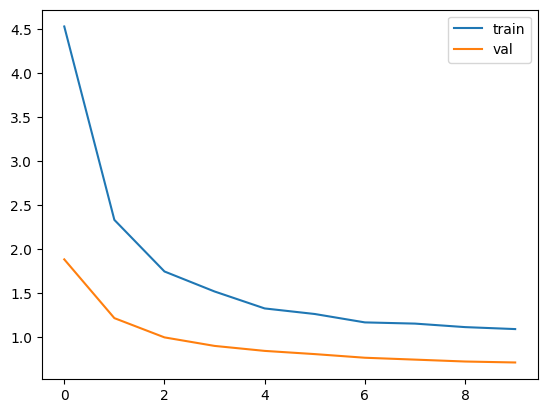

In [51]:
#plot losses
#######
#TO-DO#

plot_losses(train_loss_lst_lora, val_loss_lst_lora)

#######

In [52]:
#Compute test accuracy on MNIST 5...9 for that lora rank
#######
#TO-DO#

accuracy_lora = test(test_loader_subset2, "subset2", modified_net, {i: 0 for i in range(5, 10)})

#######

subset2: 100%|██████████| 38/38 [00:01<00:00, 27.72it/s]

Accuracy: 0.809
Wrong counts for the digit 5: 216
Wrong counts for the digit 6: 169
Wrong counts for the digit 7: 209
Wrong counts for the digit 8: 239
Wrong counts for the digit 9: 97


# Try different LoRA rank

__Question 6 (4 points) :__

Fine-tune the pre-trained model using different lora ranks [1,2,4,8,16,32,64], evaluate it on the test set
and store the number of parameters added

Make a plot showing the test accuracy as a function of lora rank. \
Compare it to the test accuracy of the pre-trained model fine-tuned in the usual way on MNIST 5...9

Conclude by looking at the number of parameters added

Discuss what are the pros of LoRA, what possible applications do you envision for it ?

In [53]:
lora_ranks = [1, 2, 4, 8, 16, 32, 64]

test_accuracies_lora = []
parameters_added_lora = []

for rank in lora_ranks:
    modified_net = ModifiedClassifier(lora_rank=rank).to(device)
    _, _ = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=10)

    test_accuracy = test(test_loader_subset2, "subset2", modified_net, {i: 0 for i in range(5, 10)})
    test_accuracies_lora.append(test_accuracy)

    parameters_added = CountLoraLayerParameters(modified_net)
    parameters_added_lora.append(parameters_added)


Training: 100%|██████████| 161/161 [00:05<00:00, 31.66it/s, loss=5.61]


Epoch [1/10] Train Loss: 5.613115377307679


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.82it/s, loss=3.38]


Epoch [1/10] Validation Loss: 3.377543857132179


Training: 100%|██████████| 161/161 [00:06<00:00, 25.24it/s, loss=3.74]


Epoch [2/10] Train Loss: 3.7387368264405625


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.40it/s, loss=2.21]


Epoch [2/10] Validation Loss: 2.20669652759165


Training: 100%|██████████| 161/161 [00:05<00:00, 27.94it/s, loss=2.89]


Epoch [3/10] Train Loss: 2.8941093053876985


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.62it/s, loss=1.69]


Epoch [3/10] Validation Loss: 1.691105562707652


Training: 100%|██████████| 161/161 [00:05<00:00, 29.44it/s, loss=2.37]


Epoch [4/10] Train Loss: 2.3684278956111173


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.80it/s, loss=1.42]


Epoch [4/10] Validation Loss: 1.4222786115563435


Training: 100%|██████████| 161/161 [00:06<00:00, 25.62it/s, loss=2.1]


Epoch [5/10] Train Loss: 2.096335277794311


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.47it/s, loss=1.32]


Epoch [5/10] Validation Loss: 1.3231392459592957


Training: 100%|██████████| 161/161 [00:05<00:00, 29.81it/s, loss=1.91]


Epoch [6/10] Train Loss: 1.9094809967538584


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.36it/s, loss=1.22]


Epoch [6/10] Validation Loss: 1.2183148048926091


Training: 100%|██████████| 161/161 [00:05<00:00, 29.34it/s, loss=1.75]


Epoch [7/10] Train Loss: 1.7495338513244012


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.13it/s, loss=1.14]


Epoch [7/10] Validation Loss: 1.139817192070726


Training: 100%|██████████| 161/161 [00:05<00:00, 27.75it/s, loss=1.67]


Epoch [8/10] Train Loss: 1.6710577847794716


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.39it/s, loss=1.1]


Epoch [8/10] Validation Loss: 1.0970510659010515


Training: 100%|██████████| 161/161 [00:05<00:00, 29.25it/s, loss=1.59]


Epoch [9/10] Train Loss: 1.5946305401576972


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.53it/s, loss=1.05]


Epoch [9/10] Validation Loss: 1.0471869456595269


Training: 100%|██████████| 161/161 [00:06<00:00, 23.26it/s, loss=1.56]


Epoch [10/10] Train Loss: 1.5576552837531759


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.96it/s, loss=1.02]


Epoch [10/10] Validation Loss: 1.0246198479680046


subset2: 100%|██████████| 38/38 [00:01<00:00, 28.26it/s]


Accuracy: 0.783
Wrong counts for the digit 5: 243
Wrong counts for the digit 6: 195
Wrong counts for the digit 7: 179
Wrong counts for the digit 8: 328
Wrong counts for the digit 9: 111
LoRA Layer l1_lora_A: 784
LoRA Layer l1_lora_B: 1000
LoRA Layer l2_lora_A: 1000
LoRA Layer l2_lora_B: 2000
LoRA Layer l3_lora_A: 2000
LoRA Layer l3_lora_B: 5
Total number of parameters: 6,789


Training: 100%|██████████| 161/161 [00:06<00:00, 24.69it/s, loss=4.38]


Epoch [1/10] Train Loss: 4.375645296173807


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.51it/s, loss=1.67]


Epoch [1/10] Validation Loss: 1.6657591678094172


Training: 100%|██████████| 161/161 [00:05<00:00, 30.10it/s, loss=2]


Epoch [2/10] Train Loss: 1.997983913984358


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.07it/s, loss=1.09]


Epoch [2/10] Validation Loss: 1.0867677417354307


Training: 100%|██████████| 161/161 [00:05<00:00, 27.14it/s, loss=1.48]


Epoch [3/10] Train Loss: 1.4803331846035785


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.18it/s, loss=0.841]


Epoch [3/10] Validation Loss: 0.8411799038665883


Training: 100%|██████████| 161/161 [00:05<00:00, 30.63it/s, loss=1.2]


Epoch [4/10] Train Loss: 1.2048012991869672


Validation: 100%|██████████| 69/69 [00:03<00:00, 22.92it/s, loss=0.762]


Epoch [4/10] Validation Loss: 0.7615135674891265


Training: 100%|██████████| 161/161 [00:05<00:00, 28.77it/s, loss=1.05]


Epoch [5/10] Train Loss: 1.046860971065782


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.59it/s, loss=0.625]


Epoch [5/10] Validation Loss: 0.6252478296342103


Training: 100%|██████████| 161/161 [00:06<00:00, 25.76it/s, loss=0.956]


Epoch [6/10] Train Loss: 0.9561923457228619


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.53it/s, loss=0.587]


Epoch [6/10] Validation Loss: 0.5874922422395237


Training: 100%|██████████| 161/161 [00:05<00:00, 30.51it/s, loss=0.923]


Epoch [7/10] Train Loss: 0.9228121982598156


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.83it/s, loss=0.549]


Epoch [7/10] Validation Loss: 0.5488743039144985


Training: 100%|██████████| 161/161 [00:05<00:00, 26.86it/s, loss=0.846]


Epoch [8/10] Train Loss: 0.8455667149576341


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.83it/s, loss=0.519]


Epoch [8/10] Validation Loss: 0.5192388343638268


Training: 100%|██████████| 161/161 [00:06<00:00, 25.64it/s, loss=0.823]


Epoch [9/10] Train Loss: 0.8230640331040258


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.79it/s, loss=0.501]


Epoch [9/10] Validation Loss: 0.5012262765912042


Training: 100%|██████████| 161/161 [00:05<00:00, 32.00it/s, loss=0.799]


Epoch [10/10] Train Loss: 0.7992305933318523


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.14it/s, loss=0.471]


Epoch [10/10] Validation Loss: 0.47099194664886035


subset2: 100%|██████████| 38/38 [00:01<00:00, 26.12it/s]


Accuracy: 0.883
Wrong counts for the digit 5: 128
Wrong counts for the digit 6: 43
Wrong counts for the digit 7: 114
Wrong counts for the digit 8: 199
Wrong counts for the digit 9: 87
LoRA Layer l1_lora_A: 1568
LoRA Layer l1_lora_B: 2000
LoRA Layer l2_lora_A: 2000
LoRA Layer l2_lora_B: 4000
LoRA Layer l3_lora_A: 4000
LoRA Layer l3_lora_B: 10
Total number of parameters: 13,578


Training: 100%|██████████| 161/161 [00:06<00:00, 26.25it/s, loss=4.01]


Epoch [1/10] Train Loss: 4.010525527948178


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.47it/s, loss=1.27]


Epoch [1/10] Validation Loss: 1.268790572449781


Training: 100%|██████████| 161/161 [00:06<00:00, 26.36it/s, loss=1.4]


Epoch [2/10] Train Loss: 1.4040045956647174


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.98it/s, loss=0.708]


Epoch [2/10] Validation Loss: 0.707561913607777


Training: 100%|██████████| 161/161 [00:05<00:00, 29.82it/s, loss=1.02]


Epoch [3/10] Train Loss: 1.0177614033592413


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.41it/s, loss=0.524]


Epoch [3/10] Validation Loss: 0.523681807777156


Training: 100%|██████████| 161/161 [00:06<00:00, 25.12it/s, loss=0.807]


Epoch [4/10] Train Loss: 0.80729268926271


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.11it/s, loss=0.434]


Epoch [4/10] Validation Loss: 0.4341656256845032


Training: 100%|██████████| 161/161 [00:05<00:00, 29.25it/s, loss=0.718]


Epoch [5/10] Train Loss: 0.7183093482292957


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.47it/s, loss=0.395]


Epoch [5/10] Validation Loss: 0.3950007745753164


Training: 100%|██████████| 161/161 [00:05<00:00, 31.59it/s, loss=0.635]


Epoch [6/10] Train Loss: 0.6347790747325613


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.13it/s, loss=0.374]


Epoch [6/10] Validation Loss: 0.3742503802413526


Training: 100%|██████████| 161/161 [00:06<00:00, 25.07it/s, loss=0.602]


Epoch [7/10] Train Loss: 0.6023373600118649


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.92it/s, loss=0.337]


Epoch [7/10] Validation Loss: 0.3373516469761945


Training: 100%|██████████| 161/161 [00:05<00:00, 28.72it/s, loss=0.545]


Epoch [8/10] Train Loss: 0.544719539258791


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.15it/s, loss=0.315]


Epoch [8/10] Validation Loss: 0.3152110086403031


Training: 100%|██████████| 161/161 [00:05<00:00, 27.34it/s, loss=0.519]


Epoch [9/10] Train Loss: 0.5189804666160797


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.83it/s, loss=0.302]


Epoch [9/10] Validation Loss: 0.30246950837149134


Training: 100%|██████████| 161/161 [00:05<00:00, 26.92it/s, loss=0.487]


Epoch [10/10] Train Loss: 0.48679289860384806


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.32it/s, loss=0.284]


Epoch [10/10] Validation Loss: 0.2843467228222584


subset2: 100%|██████████| 38/38 [00:01<00:00, 29.53it/s]


Accuracy: 0.915
Wrong counts for the digit 5: 96
Wrong counts for the digit 6: 38
Wrong counts for the digit 7: 64
Wrong counts for the digit 8: 145
Wrong counts for the digit 9: 69
LoRA Layer l1_lora_A: 3136
LoRA Layer l1_lora_B: 4000
LoRA Layer l2_lora_A: 4000
LoRA Layer l2_lora_B: 8000
LoRA Layer l3_lora_A: 8000
LoRA Layer l3_lora_B: 20
Total number of parameters: 27,156


Training: 100%|██████████| 161/161 [00:05<00:00, 28.82it/s, loss=4.41]


Epoch [1/10] Train Loss: 4.412875824093078


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.61it/s, loss=1.48]


Epoch [1/10] Validation Loss: 1.4761709104413572


Training: 100%|██████████| 161/161 [00:05<00:00, 27.89it/s, loss=1.57]


Epoch [2/10] Train Loss: 1.5653679892883539


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.41it/s, loss=0.721]


Epoch [2/10] Validation Loss: 0.7213280395321224


Training: 100%|██████████| 161/161 [00:06<00:00, 26.75it/s, loss=0.986]


Epoch [3/10] Train Loss: 0.9858863055706024


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.16it/s, loss=0.506]


Epoch [3/10] Validation Loss: 0.5059660640747651


Training: 100%|██████████| 161/161 [00:05<00:00, 29.60it/s, loss=0.779]


Epoch [4/10] Train Loss: 0.7786170529282611


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.02it/s, loss=0.398]


Epoch [4/10] Validation Loss: 0.39797581818656647


Training: 100%|██████████| 161/161 [00:06<00:00, 25.77it/s, loss=0.64]


Epoch [5/10] Train Loss: 0.6395157899545587


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.14it/s, loss=0.351]


Epoch [5/10] Validation Loss: 0.35095631795516913


Training: 100%|██████████| 161/161 [00:05<00:00, 29.56it/s, loss=0.57]


Epoch [6/10] Train Loss: 0.5700441056526966


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.76it/s, loss=0.299]


Epoch [6/10] Validation Loss: 0.298896976787111


Training: 100%|██████████| 161/161 [00:06<00:00, 23.90it/s, loss=0.511]


Epoch [7/10] Train Loss: 0.5113707427282511


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.75it/s, loss=0.271]


Epoch [7/10] Validation Loss: 0.2708750490261161


Training: 100%|██████████| 161/161 [00:06<00:00, 26.50it/s, loss=0.469]


Epoch [8/10] Train Loss: 0.4686801173487065


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.86it/s, loss=0.258]


Epoch [8/10] Validation Loss: 0.25752425247776334


Training: 100%|██████████| 161/161 [00:05<00:00, 31.59it/s, loss=0.44]


Epoch [9/10] Train Loss: 0.44018497757659936


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.13it/s, loss=0.231]


Epoch [9/10] Validation Loss: 0.23070552124493365


Training: 100%|██████████| 161/161 [00:06<00:00, 26.52it/s, loss=0.405]


Epoch [10/10] Train Loss: 0.40475703090984627


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.71it/s, loss=0.228]


Epoch [10/10] Validation Loss: 0.22835058416577353


subset2: 100%|██████████| 38/38 [00:01<00:00, 28.71it/s]


Accuracy: 0.94
Wrong counts for the digit 5: 47
Wrong counts for the digit 6: 23
Wrong counts for the digit 7: 42
Wrong counts for the digit 8: 116
Wrong counts for the digit 9: 66
LoRA Layer l1_lora_A: 6272
LoRA Layer l1_lora_B: 8000
LoRA Layer l2_lora_A: 8000
LoRA Layer l2_lora_B: 16000
LoRA Layer l3_lora_A: 16000
LoRA Layer l3_lora_B: 40
Total number of parameters: 54,312


Training: 100%|██████████| 161/161 [00:06<00:00, 25.37it/s, loss=4.12]


Epoch [1/10] Train Loss: 4.123874680596109


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.55it/s, loss=1.24]


Epoch [1/10] Validation Loss: 1.2391036316968393


Training: 100%|██████████| 161/161 [00:05<00:00, 30.74it/s, loss=1.21]


Epoch [2/10] Train Loss: 1.2078782031254738


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.64it/s, loss=0.541]


Epoch [2/10] Validation Loss: 0.5405568851940874


Training: 100%|██████████| 161/161 [00:06<00:00, 26.41it/s, loss=0.731]


Epoch [3/10] Train Loss: 0.7308156779093772


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.87it/s, loss=0.375]


Epoch [3/10] Validation Loss: 0.3745446911324625


Training: 100%|██████████| 161/161 [00:06<00:00, 25.04it/s, loss=0.568]


Epoch [4/10] Train Loss: 0.5679220876523426


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.97it/s, loss=0.308]


Epoch [4/10] Validation Loss: 0.3082033542619235


Training: 100%|██████████| 161/161 [00:05<00:00, 30.67it/s, loss=0.503]


Epoch [5/10] Train Loss: 0.5032514525311333


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.48it/s, loss=0.269]


Epoch [5/10] Validation Loss: 0.26939291366632434


Training: 100%|██████████| 161/161 [00:06<00:00, 25.09it/s, loss=0.433]


Epoch [6/10] Train Loss: 0.43269298119204386


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.19it/s, loss=0.237]


Epoch [6/10] Validation Loss: 0.2373947996808135


Training: 100%|██████████| 161/161 [00:05<00:00, 28.83it/s, loss=0.394]


Epoch [7/10] Train Loss: 0.39438700925859604


Validation: 100%|██████████| 69/69 [00:03<00:00, 21.43it/s, loss=0.217]


Epoch [7/10] Validation Loss: 0.2171142292411431


Training: 100%|██████████| 161/161 [00:05<00:00, 31.08it/s, loss=0.356]


Epoch [8/10] Train Loss: 0.35577560433689853


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.25it/s, loss=0.198]


Epoch [8/10] Validation Loss: 0.19815660894349002


Training: 100%|██████████| 161/161 [00:06<00:00, 25.13it/s, loss=0.34]


Epoch [9/10] Train Loss: 0.339847894281334


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.37it/s, loss=0.189]


Epoch [9/10] Validation Loss: 0.18866383446299512


Training: 100%|██████████| 161/161 [00:05<00:00, 29.29it/s, loss=0.311]


Epoch [10/10] Train Loss: 0.3106102115989472


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.19it/s, loss=0.178]


Epoch [10/10] Validation Loss: 0.17822794108719064


subset2: 100%|██████████| 38/38 [00:01<00:00, 19.30it/s]


Accuracy: 0.947
Wrong counts for the digit 5: 44
Wrong counts for the digit 6: 19
Wrong counts for the digit 7: 40
Wrong counts for the digit 8: 100
Wrong counts for the digit 9: 53
LoRA Layer l1_lora_A: 12544
LoRA Layer l1_lora_B: 16000
LoRA Layer l2_lora_A: 16000
LoRA Layer l2_lora_B: 32000
LoRA Layer l3_lora_A: 32000
LoRA Layer l3_lora_B: 80
Total number of parameters: 108,624


Training: 100%|██████████| 161/161 [00:05<00:00, 30.26it/s, loss=4.56]


Epoch [1/10] Train Loss: 4.5578692077849965


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.78it/s, loss=1.72]


Epoch [1/10] Validation Loss: 1.717411938784779


Training: 100%|██████████| 161/161 [00:06<00:00, 24.48it/s, loss=1.34]


Epoch [2/10] Train Loss: 1.341459362032991


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.86it/s, loss=0.562]


Epoch [2/10] Validation Loss: 0.5623638217431911


Training: 100%|██████████| 161/161 [00:05<00:00, 28.80it/s, loss=0.72]


Epoch [3/10] Train Loss: 0.7197886871995393


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.77it/s, loss=0.339]


Epoch [3/10] Validation Loss: 0.33891384346761566


Training: 100%|██████████| 161/161 [00:06<00:00, 26.25it/s, loss=0.516]


Epoch [4/10] Train Loss: 0.5162177612507566


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.06it/s, loss=0.252]


Epoch [4/10] Validation Loss: 0.2524291337400243


Training: 100%|██████████| 161/161 [00:06<00:00, 25.00it/s, loss=0.417]


Epoch [5/10] Train Loss: 0.41682881625912943


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.51it/s, loss=0.206]


Epoch [5/10] Validation Loss: 0.20604618044867032


Training: 100%|██████████| 161/161 [00:05<00:00, 29.25it/s, loss=0.361]


Epoch [6/10] Train Loss: 0.3607841609797863


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.68it/s, loss=0.181]


Epoch [6/10] Validation Loss: 0.1810994567754476


Training: 100%|██████████| 161/161 [00:06<00:00, 25.91it/s, loss=0.311]


Epoch [7/10] Train Loss: 0.3112201976665058


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.32it/s, loss=0.166]


Epoch [7/10] Validation Loss: 0.1662149327820626


Training: 100%|██████████| 161/161 [00:05<00:00, 27.51it/s, loss=0.293]


Epoch [8/10] Train Loss: 0.29288237148560353


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.29it/s, loss=0.154]


Epoch [8/10] Validation Loss: 0.1536429659395978


Training: 100%|██████████| 161/161 [00:05<00:00, 29.45it/s, loss=0.267]


Epoch [9/10] Train Loss: 0.2674520910248993


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.17it/s, loss=0.141]


Epoch [9/10] Validation Loss: 0.14066687312679013


Training: 100%|██████████| 161/161 [00:06<00:00, 26.10it/s, loss=0.246]


Epoch [10/10] Train Loss: 0.2459737202673225


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.32it/s, loss=0.134]


Epoch [10/10] Validation Loss: 0.13355751319423967


subset2: 100%|██████████| 38/38 [00:01<00:00, 29.04it/s]


Accuracy: 0.962
Wrong counts for the digit 5: 36
Wrong counts for the digit 6: 19
Wrong counts for the digit 7: 27
Wrong counts for the digit 8: 54
Wrong counts for the digit 9: 50
LoRA Layer l1_lora_A: 25088
LoRA Layer l1_lora_B: 32000
LoRA Layer l2_lora_A: 32000
LoRA Layer l2_lora_B: 64000
LoRA Layer l3_lora_A: 64000
LoRA Layer l3_lora_B: 160
Total number of parameters: 217,248


Training: 100%|██████████| 161/161 [00:05<00:00, 27.43it/s, loss=4.35]


Epoch [1/10] Train Loss: 4.352126787167899


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.59it/s, loss=1.58]


Epoch [1/10] Validation Loss: 1.577645320823227


Training: 100%|██████████| 161/161 [00:05<00:00, 28.11it/s, loss=1.29]


Epoch [2/10] Train Loss: 1.2912891951406964


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.18it/s, loss=0.544]


Epoch [2/10] Validation Loss: 0.5444097130194955


Training: 100%|██████████| 161/161 [00:06<00:00, 26.11it/s, loss=0.664]


Epoch [3/10] Train Loss: 0.663922017960815


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.41it/s, loss=0.341]


Epoch [3/10] Validation Loss: 0.34148043134938116


Training: 100%|██████████| 161/161 [00:06<00:00, 24.15it/s, loss=0.468]


Epoch [4/10] Train Loss: 0.4677717858775062


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.64it/s, loss=0.255]


Epoch [4/10] Validation Loss: 0.25521418786999106


Training: 100%|██████████| 161/161 [00:05<00:00, 28.81it/s, loss=0.381]


Epoch [5/10] Train Loss: 0.38058287155183945


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.73it/s, loss=0.213]


Epoch [5/10] Validation Loss: 0.21315935858781787


Training: 100%|██████████| 161/161 [00:06<00:00, 25.05it/s, loss=0.322]


Epoch [6/10] Train Loss: 0.3224444496705665


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.77it/s, loss=0.186]


Epoch [6/10] Validation Loss: 0.18623127728916597


Training: 100%|██████████| 161/161 [00:05<00:00, 29.24it/s, loss=0.276]


Epoch [7/10] Train Loss: 0.27613980910792857


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.78it/s, loss=0.165]


Epoch [7/10] Validation Loss: 0.1654218351603418


Training: 100%|██████████| 161/161 [00:05<00:00, 27.01it/s, loss=0.263]


Epoch [8/10] Train Loss: 0.2634423261751299


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.18it/s, loss=0.154]


Epoch [8/10] Validation Loss: 0.15418229484255763


Training: 100%|██████████| 161/161 [00:06<00:00, 26.00it/s, loss=0.238]


Epoch [9/10] Train Loss: 0.23776808941031094


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.73it/s, loss=0.139]


Epoch [9/10] Validation Loss: 0.13917132040512734


Training: 100%|██████████| 161/161 [00:05<00:00, 28.40it/s, loss=0.216]


Epoch [10/10] Train Loss: 0.21601604971086016


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.72it/s, loss=0.131]


Epoch [10/10] Validation Loss: 0.13082963147241136


subset2: 100%|██████████| 38/38 [00:01<00:00, 19.81it/s]

Accuracy: 0.96
Wrong counts for the digit 5: 37
Wrong counts for the digit 6: 17
Wrong counts for the digit 7: 21
Wrong counts for the digit 8: 72
Wrong counts for the digit 9: 48
LoRA Layer l1_lora_A: 50176
LoRA Layer l1_lora_B: 64000
LoRA Layer l2_lora_A: 64000
LoRA Layer l2_lora_B: 128000
LoRA Layer l3_lora_A: 128000
LoRA Layer l3_lora_B: 320
Total number of parameters: 434,496


In [56]:
# Number of Parameters added
print("Number of Parameters Added in each Rank")
for i in range(len(lora_ranks)):
  print(f'Rank {lora_ranks[i]}: {parameters_added_lora[i]}')
  print("---")

Number of Parameters Added in each Rank
Rank 1: 6789
---
Rank 2: 13578
---
Rank 4: 27156
---
Rank 8: 54312
---
Rank 16: 108624
---
Rank 32: 217248
---
Rank 64: 434496
---


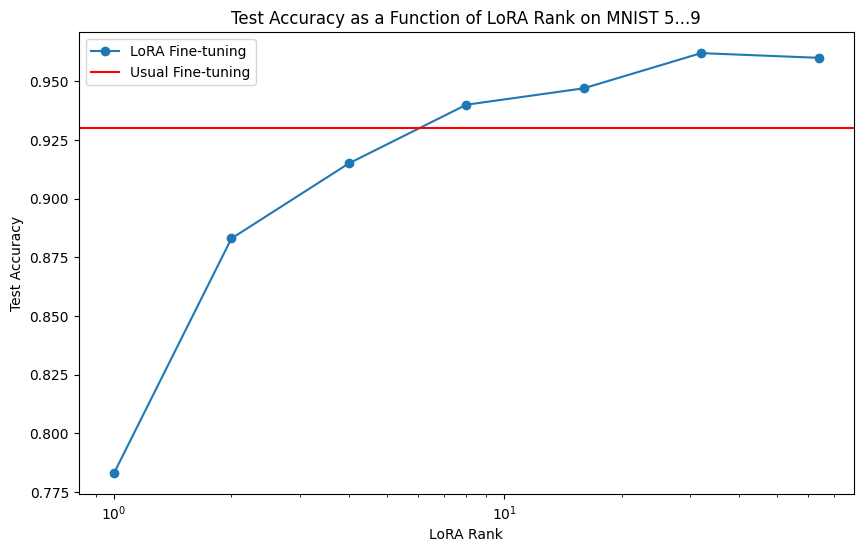

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(lora_ranks, test_accuracies_lora, label='LoRA Fine-tuning', marker='o')
plt.axhline(y=accuracy_subset2, color='r', linestyle='-', label='Usual Fine-tuning')
plt.xlabel('LoRA Rank')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy as a Function of LoRA Rank on MNIST 5...9')
plt.legend()
plt.xscale('log')
plt.show()

**[Observation]**  
The paper originally stated to "simply set α to the first r we try and do not tune it." We disagree with this statement. Numerous values of alphas have been tested. The alpha value used the final model is 64, with $\Delta{Wx} \times \frac{\alpha}{r}$ applied in the LoRA linear layers. Generally speaking, as the LoRA rank increases, the test accuracy increases at the same time, along with an increase in the number of parameters added as well. However, while the second last LoRA rank (=32) reached the highest accuracy, the last LoRA rank (=64) appears to have a slight drop in accuracy, and the trend becomes flatter. We also observe that the LoRA approach can further fine-tune and achieve better accuracy than the usual fune-tuning method. Unlike what was stated in the paper, this exercise suggests that the both alpha value and the rank are hyperparameters to be determined to achieve an excellent performance in LoRA models.  

---
**[What are the pros of LoRA?]**  
- *Computational Efficiency* : It only updates a small fraction of the model's parameters so that it is able to save computational resources and thus enables the adaptation of very large models without retraining all again.

- *Flexibility* : Able to fine-tune models for new tasks without largely forgetting pre-trained model parameters.

- *Scalability* : As models become larger, fine-tuning and retraining entirely become impossible. LoRA's method scales better because the number of parameters added does not grow proportionally with the model size.

---
**[What possible applications do you envision for LoRA?]**  
- *Transfer Learning* : LoRA can be applied when adapting LLMs to specific domains or tasks, for example, legal document analysis or information extraction.

- *Edge Computing* : For applications where the model needs to be deployed on devices with limited computational resources, LoRA fine-tuning allows the deployment of powerful models in a resource-constrained environment.

- *Personalization* : In some cases, like product recommendation systems, the personalization is key. Therefore, LoRA can quickly adapt a general model to individual users' preferences without extensive retraining.